In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from tqdm import tqdm


In [3]:
def apply_along_axis(f, data, axis):
    return torch.stack([
        f(i) for i in torch.unbind(data, dim=axis)
    ])

def entropy(X):
    return -1 * torch.sum(torch.log(X) * X)

In [4]:
from models import MLP, MLP_SM

In [5]:
trainset = torchvision.datasets.MNIST(root='./data', 
                                      train=True,
                                      download=False,
                                     transform=transforms.ToTensor()
                                     )

testset = torchvision.datasets.MNIST(root='./data', 
                                      train=False,
                                      download=False,
                                     transform=transforms.ToTensor()
                                     )


In [6]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=batch_size)


In [7]:
mse = nn.MSELoss()

In [248]:
def run_sample(model, loss_fn, optim, sample, train=True):
    if train: optim.zero_grad()
    x, y = sample
    x = torch.flatten(x.squeeze(1), start_dim=1)
    y_pred, aux = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    if train: optim.step()
    if train:
        return loss.item()
    else:
        return loss.item(), y_pred, aux
    
def run_sample_SM(model, loss_fn, optim, sample, train=True):
    if train: optim.zero_grad()
    x, y = sample
    x = torch.flatten(x.squeeze(1), start_dim=1)
    
    y_pred, aux = model(x)
    loss_main = loss_fn(y_pred[:,:10], y)
    loss_aux = mse(y_pred[:,10:], aux)
    #print(f'loss_main: {loss_main}, loss_aux: {loss_aux}')
    loss = loss_main + 100*loss_aux
    loss.backward()
    if train: optim.step()
    if train:
        return loss.item()
    else:
        return loss.item(), y_pred, aux

In [249]:
def train_model(num_epochs, model, run_fn, train_data, test_data):
    loss_fn = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    train_losses = []
    val_losses = []
    acc_list = []
    for e in range(num_epochs):
        tr_loss = 0
        val_loss = 0
        accuracy = 0
        hid_stdev = 0
        hid_entropy = 0
        
        for sample in train_data:
            unit_loss = run_fn(model, loss_fn, optim, sample)
            tr_loss += unit_loss
        for sample in test_data:
            unit_loss, preds, aux = run_fn(model, loss_fn, None, sample, train=False)
            preds = torch.argmax(preds[:,:10], dim=1)
            val_loss += unit_loss
            accuracy += sum(preds == sample[1]).item() / 16 # sum of matches in y and y_hat
            hid_stdev += aux.std(1).mean()
            hid_entropy += apply_along_axis(entropy, aux, 0).mean().item()


        tr_loss /= len(train_data)
        val_loss /= len(test_data)
        accuracy /= len(test_data)
        hid_stdev /= len(test_data)
        hid_entropy /= len(test_data)
        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        acc_list.append(accuracy)
        print(f"Epoch {e} \t{'. '*5}train loss: {round(tr_loss,5)}\tVal: {round(val_loss,5)}\tAcc: {accuracy}")
        print(f"Target hid layer mean stdev: {hid_stdev} \tEntropy: {hid_entropy}")
      
    plt.plot(train_losses)
    plt.plot(val_losses)
    #plt.plot(acc_list)
    plt.show()

In [250]:
torch.manual_seed(1337)
model1 = MLP(784, 10, hidden_dims=[128])
torch.manual_seed(1337)
model2 = MLP_SM(784, 10, hidden_dims=[128], aux_layer=1)

In [251]:
epochs = 25

Epoch 0 	. . . . . train loss: 0.74198	Val: 0.34472	Acc: 0.9121
Target hid layer mean stdev: 0.25210604071617126 	Entropy: 35.56663938598633
Epoch 1 	. . . . . train loss: 0.30004	Val: 0.25197	Acc: 0.9328
Target hid layer mean stdev: 0.29995304346084595 	Entropy: 30.956347500610352
Epoch 2 	. . . . . train loss: 0.21868	Val: 0.18725	Acc: 0.9481
Target hid layer mean stdev: 0.34122565388679504 	Entropy: 25.62892353210449
Epoch 3 	. . . . . train loss: 0.15999	Val: 0.14819	Acc: 0.9596
Target hid layer mean stdev: 0.3652786314487457 	Entropy: 22.07165732421875
Epoch 4 	. . . . . train loss: 0.12004	Val: 0.12699	Acc: 0.9629
Target hid layer mean stdev: 0.38035762310028076 	Entropy: 19.918494390869142
Epoch 5 	. . . . . train loss: 0.09531	Val: 0.10699	Acc: 0.9689
Target hid layer mean stdev: 0.39040884375572205 	Entropy: 18.39645757751465
Epoch 6 	. . . . . train loss: 0.07802	Val: 0.09488	Acc: 0.9693
Target hid layer mean stdev: 0.395317018032074 	Entropy: 17.437843127441408
Epoch 7 	. . 

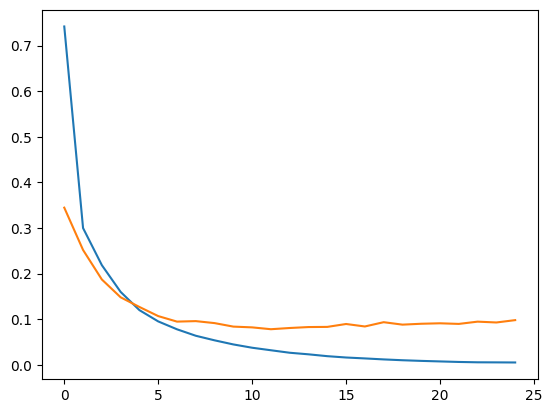

In [252]:
train_model(epochs, model2, run_sample_SM, trainloader, testloader)

Epoch 0 	. . . . . train loss: 0.36653	Val: 0.19223	Acc: 0.945
Target hid layer mean stdev: 0.39237406849861145 	Entropy: 19.556263854980468
Epoch 1 	. . . . . train loss: 0.16219	Val: 0.13209	Acc: 0.9606
Target hid layer mean stdev: 0.4103054702281952 	Entropy: 16.854388639831544
Epoch 2 	. . . . . train loss: 0.11389	Val: 0.10414	Acc: 0.9685
Target hid layer mean stdev: 0.4188584089279175 	Entropy: 15.44753568572998
Epoch 3 	. . . . . train loss: 0.08536	Val: 0.09541	Acc: 0.9704
Target hid layer mean stdev: 0.4239819347858429 	Entropy: 14.51189500427246
Epoch 4 	. . . . . train loss: 0.06696	Val: 0.08332	Acc: 0.9732
Target hid layer mean stdev: 0.42820313572883606 	Entropy: 13.831013694763184
Epoch 5 	. . . . . train loss: 0.05383	Val: 0.07732	Acc: 0.9772
Target hid layer mean stdev: 0.4312569200992584 	Entropy: 13.317734761047364
Epoch 6 	. . . . . train loss: 0.0438	Val: 0.07735	Acc: 0.976
Target hid layer mean stdev: 0.43392616510391235 	Entropy: 12.884685116577149
Epoch 7 	. . . 

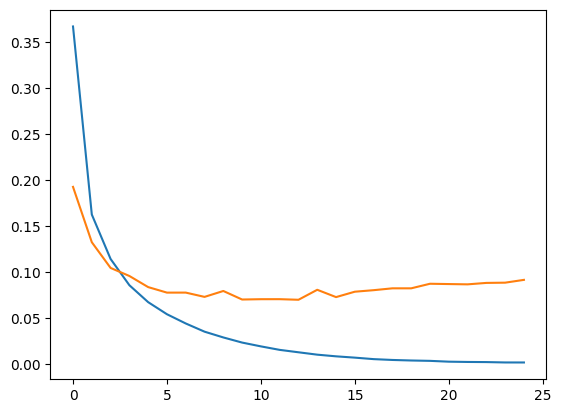

In [253]:
train_model(epochs, model1, run_sample, trainloader, testloader)

In [254]:
testiter = iter(testloader)
sample = next(testiter)

In [255]:
loss_fn = nn.CrossEntropyLoss()

loss1, pred1, aux1, = run_sample(model1, loss_fn, None, sample, train=False)
loss2, pred2, aux2, = run_sample_SM(model2, loss_fn, None, sample, train=False)

In [263]:
entropy(aux1[0])

tensor(6.9199, grad_fn=<MulBackward0>)

In [267]:
entropy(aux2[1])

tensor(6.3156, grad_fn=<MulBackward0>)

tensor(4.0690, grad_fn=<MulBackward0>)


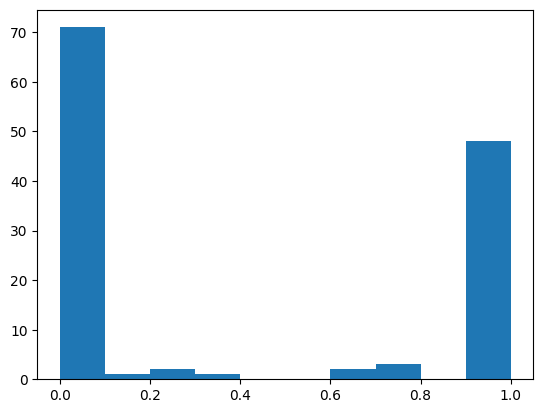

In [282]:
print(entropy(aux1[1]))
plt.hist(aux1[1].detach().numpy())
plt.show()

In [142]:
for i in list(model2.parameters()):
    print(i.shape)
    

torch.Size([128, 784])
torch.Size([128])
torch.Size([138, 128])
torch.Size([138])


In [304]:
128*784

100352

In [303]:
model2

MLP_SM(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (fc_out): Linear(in_features=128, out_features=138, bias=True)
)

In [276]:
m1w1 = list(model1.parameters())[0].detach().numpy()
m1w2 = list(model1.parameters())[2].detach().numpy()

m2w1 = list(model2.parameters())[0].detach().numpy()
m2w2 = list(model2.parameters())[2].detach().numpy()


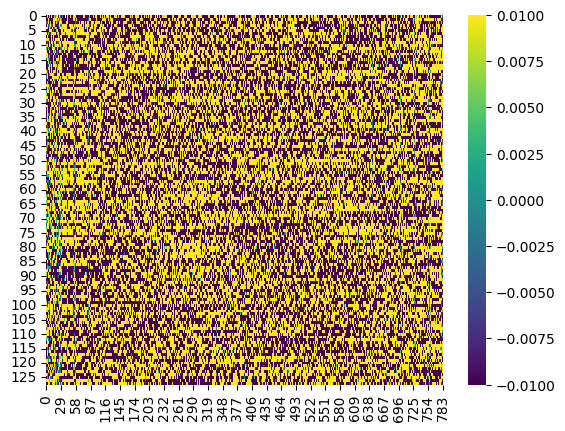

In [301]:
sns.heatmap(m1w1, vmin=-0.01, vmax=0.01, cmap='viridis')
plt.show()

In [158]:
aux_np = aux.detach().numpy().transpose(1,0)

pred_np = pred.detach().numpy().T

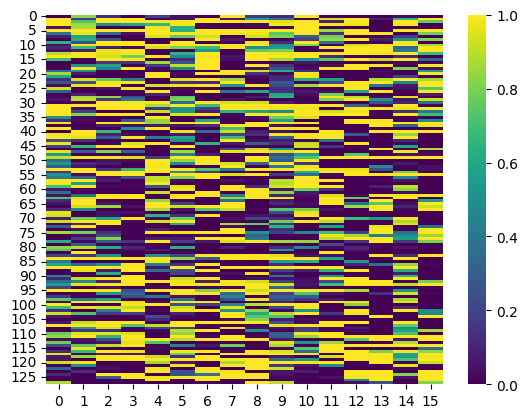

In [170]:
sns.heatmap(aux_np, cmap='viridis')
plt.show()

In [187]:
out = param2 @ aux_np
out.shape

(138, 16)

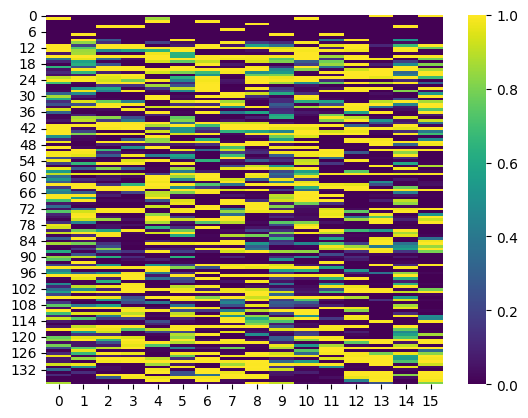

In [188]:
sns.heatmap(out, vmin=0, vmax=1, cmap='viridis')
plt.show()

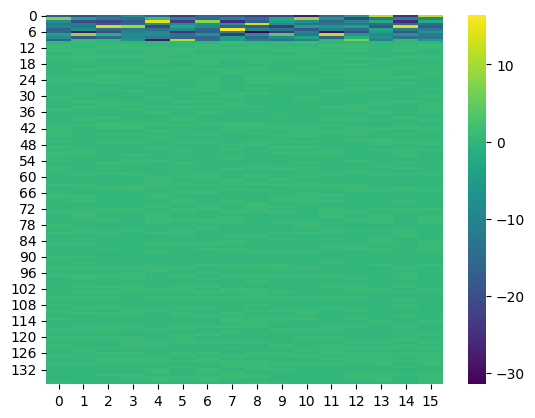

In [169]:
sns.heatmap(pred_np, cmap='viridis')
plt.show()

In [182]:
pred_np[:20, 0]

array([-1.8349953e+01,  6.9929385e+00, -7.8968091e+00, -1.1772191e+01,
       -1.0117724e+01, -1.6094769e+01, -1.5692889e+01, -4.7773018e+00,
       -7.8877168e+00, -1.6237440e+01,  2.9359569e-03,  1.0042810e+00,
        9.9754000e-01,  9.9877685e-01,  5.6531034e-02,  1.0026363e+00,
        3.8304079e-01,  9.7786680e-02,  1.1679847e-03,  6.4975709e-01],
      dtype=float32)

In [186]:
pred.transpose(1,0)[:20,0]

tensor([-1.8350e+01,  6.9929e+00, -7.8968e+00, -1.1772e+01, -1.0118e+01,
        -1.6095e+01, -1.5693e+01, -4.7773e+00, -7.8877e+00, -1.6237e+01,
         2.9360e-03,  1.0043e+00,  9.9754e-01,  9.9878e-01,  5.6531e-02,
         1.0026e+00,  3.8304e-01,  9.7787e-02,  1.1680e-03,  6.4976e-01],
       grad_fn=<SelectBackward0>)

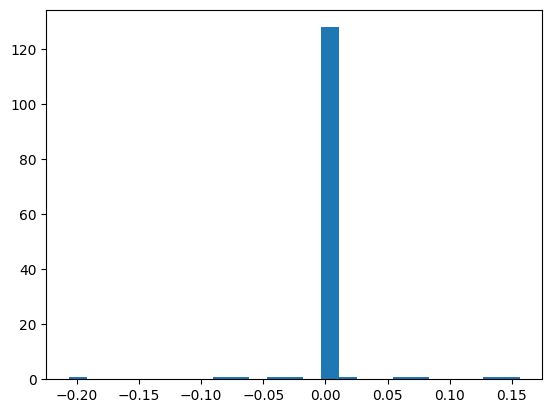

In [162]:
plt.hist(param3, bins=25)
plt.show()